In [1]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torchvision.transforms as transforms
import math
from Antolik_dataset import AntolikDataset
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance

In [2]:
save = False

plt.rcParams.update({'font.size': 12})
factor = 5.5
img_path = "img/"

stimulus_resolution = 110 # it is a square stimulus

In [3]:
keep_visual_field = 0.8 # this is how much of visual field (out of 2) is kept (from the middle). The rest is cropped out

# neurons are from -2 to +2, when normalized to [-1, 1] (where, stimulus is presented to the whole area of [-1, 1]),
# we want to know how much of the space the neurons allocate. All the following computations are only in one quadrant
normalized_area_of_neurons = 2/factor # ~0.36.. out of 1
# given a crop of neurons (keep_visual_field), we want to know, how many pixels from the stimulus we can crop

cropped_neurons = 2-keep_visual_field
ratio_of_cropped_neurons = cropped_neurons / 2

normalized_area_of_cropped_neurons = normalized_area_of_neurons * ratio_of_cropped_neurons


discard_pixels_each_side = math.floor((stimulus_resolution/2) * normalized_area_of_cropped_neurons)


print(str(discard_pixels_each_side) + "px will be discarded from each side.")

12px will be discarded from each side.


In [4]:
############################ ON ANTOLIK'S DATASET ##############################

model_class = reCNN_bottleneck_CyclicGauss3d
m = download_model(artifact_name="csng-cuni/reCNN_visual_prosthesis/model-abwwf3vs:v0", model_class)

x, y, ori = get_neuron_estimates(m, factor) # returns already scaled positions (by factor)

TypeError: download_model() missing 1 required positional argument: 'model_class'

In [ ]:


path_train = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/one_trials.pickle"
path_test = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/ten_trials.pickle"


In [ ]:
d = AntolikDataset(path_train)

#### Get indices

In [ ]:
indices = d.get_indices()
print(indices[0])

{"module_path" :"mozaik.stimuli.vision.topographica_based","background_luminance":50.0, "blank_duration":490.0, "density":10.0, "direct_stimulation_name":None, "direct_stimulation_parameters":None, "duration":1050, "frame_duration":7.0, "image_duration":560.0, "image_location":'/projects/imagenet/val/ILSVRC2012_val_00000001.JPEG', "location_x":0.0, "location_y":0.0, "name":'NaturalImage', "size":11, "size_x":11.0, "size_y":11.0, "trial":0}


#### Visualization and cropping of the stimulus

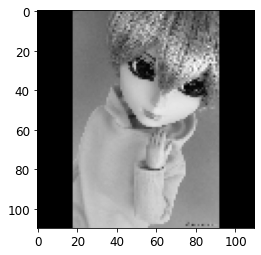

In [ ]:
d.visualize(indices[69])

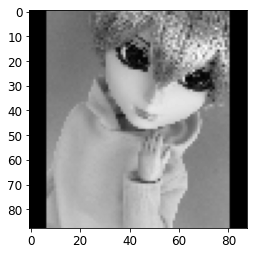

In [ ]:
d.set_stimulus_crop((110 - 2*discard_pixels_each_side, 110 - 2*discard_pixels_each_side))
d.visualize(indices[69])

In [ ]:
print(d.stimulus_crop)

(88, 88)


#### Brain crop

In [ ]:
stimulus, response = d[indices[69]]
print(response.shape)
d.set_brain_crop(keep_visual_field)
stimulus, response = d[indices[69]]
print(response.shape)

torch.Size([5299])
torch.Size([5299])


In [ ]:
print(stimulus.shape)

torch.Size([1, 80, 80])
